# 实时负载预测与资源管理 - 高级建模

本笔记本将使用扩展特征集实现更先进的预测模型。基于处理过的数据，我们将探索更复杂的特征工程和模型架构。

In [238]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# 机器学习库
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

# 深度学习库
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tf_available = True
except ImportError:
    print("警告: TensorFlow不可用，LSTM模型将不可用")
    tf_available = False

# 设置可视化样式
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 1. 数据加载与探索

In [239]:
# 加载扩展特征集的数据
data_path = '../processed_data/c7_user_fxHzmdZ_timeseries.csv'

try:
    df = pd.read_csv(data_path)
    print(f"成功读取数据，形状: {df.shape}")
    
    # 显示前几行数据
    display(df.head())
    
    # 查看数据类型和基本信息
    display(df.info())
    
    # 查看数值特征的统计摘要
    display(df.describe())
    
except Exception as e:
    print(f"读取数据时出错: {e}")

成功读取数据，形状: (2215, 20)


,user,time_dt,collection_id,collection_name,collection_logical_name,start_time_dt,end_time_dt,cpu_usage_distribution,tail_cpu_usage_distribution,priority,instance_index,event,failed,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour
0,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:38:32.222809,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,42,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
1,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:38:32.892376,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,39,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
2,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:39:00.576619,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,18,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
3,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:40:00.059573,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,24,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
4,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:52:14.119349,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,22,SCHEDULE,0,0.007042,0.007790,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user                         2215 non-null   object 
 1   time_dt                      2215 non-null   object 
 2   collection_id                2215 non-null   int64  
 3   collection_name              2215 non-null   object 
 4   collection_logical_name      2215 non-null   object 
 5   start_time_dt                2215 non-null   object 
 6   end_time_dt                  2215 non-null   object 
 7   cpu_usage_distribution       2215 non-null   object 
 8   tail_cpu_usage_distribution  2215 non-null   object 
 9   priority                     2215 non-null   int64  
 10  instance_index               2215 non-null   int64  
 11  event                        2215 non-null   object 
 12  failed                       2215 non-null   int64  
 13  resource_request_c

None

,collection_id,priority,instance_index,failed,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
count,2.215000e+03,2215.0,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2.215000e+03,2215.000000,2.215000e+03
mean,2.861125e+11,103.0,108.065011,0.002257,0.007918,0.020131,0.003214,8.816644e-04,0.006203,1.225342e-03
std,4.950985e+09,0.0,72.391284,0.047468,0.015365,0.030076,0.010281,1.274778e-03,0.014878,2.195962e-03
min,2.789693e+11,103.0,0.000000,0.000000,0.000705,0.000957,0.000000,9.536743e-07,0.000000,9.536743e-07
25%,2.818722e+11,103.0,42.000000,0.000000,0.000880,0.001465,0.000232,1.916885e-04,0.000618,3.757477e-04
50%,2.854463e+11,103.0,98.000000,0.000000,0.001760,0.006866,0.000339,6.628036e-04,0.000840,6.866455e-04
75%,2.876527e+11,103.0,168.500000,0.000000,0.007393,0.023895,0.001024,8.382797e-04,0.004105,1.094818e-03
max,2.980688e+11,103.0,249.000000,1.000000,0.097900,0.188721,0.079346,9.140015e-03,0.126221,1.246643e-02


### 1.1 检查缺失值

In [240]:
# 检查缺失值
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    '缺失值数量': missing_values,
    '缺失百分比': missing_percentage
}).sort_values('缺失百分比', ascending=False)

display(missing_df[missing_df['缺失值数量'] > 0])

,缺失值数量,缺失百分比


### 1.2 时间特征检查与转换

In [241]:
# 检查并转换时间特征
time_columns = [col for col in df.columns if 'time' in col.lower() and 'dt' not in col.lower()]
print(f"时间相关列: {time_columns}")

for col in time_columns:
    if col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            df[f'{col}_dt'] = pd.to_datetime(df[col], unit='us')
            print(f"转换列 {col} 为日期时间格式")

# 确保有时间序列索引
if 'time_dt' in df.columns:
    # 将时间列设为索引
    df_ts = df.set_index('time_dt').sort_index()
    print("已将时间列设为索引并排序")
    display(df_ts.head())
else:
    print("没有找到time_dt列，检查时间列转换")

时间相关列: []
已将时间列设为索引并排序


,user,collection_id,collection_name,collection_logical_name,start_time_dt,end_time_dt,cpu_usage_distribution,tail_cpu_usage_distribution,priority,instance_index,event,failed,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour
time_dt,,,,,,,,,,,,,,,,,,,
1970-01-04 10:38:32.222809,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,42,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
1970-01-04 10:38:32.892376,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,39,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
1970-01-04 10:39:00.576619,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,18,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
1970-01-04 10:40:00.059573,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,24,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00
1970-01-04 10:52:14.119349,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,22,SCHEDULE,0,0.007042,0.007790,0.005157,0.003006,0.021393,0.00309,1970-01-04 10:00:00


### 1.3 目标变量的分布与时间序列可视化

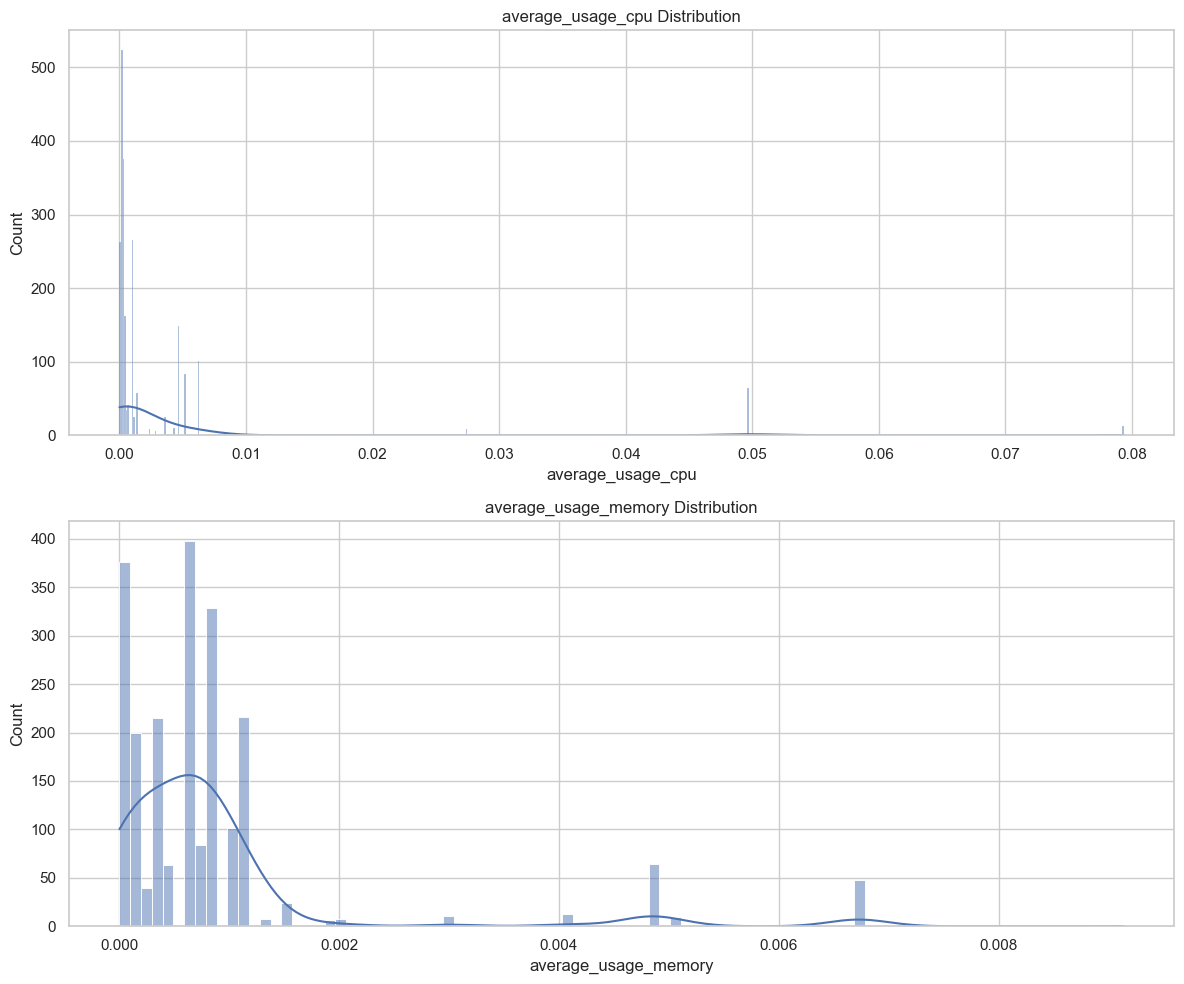

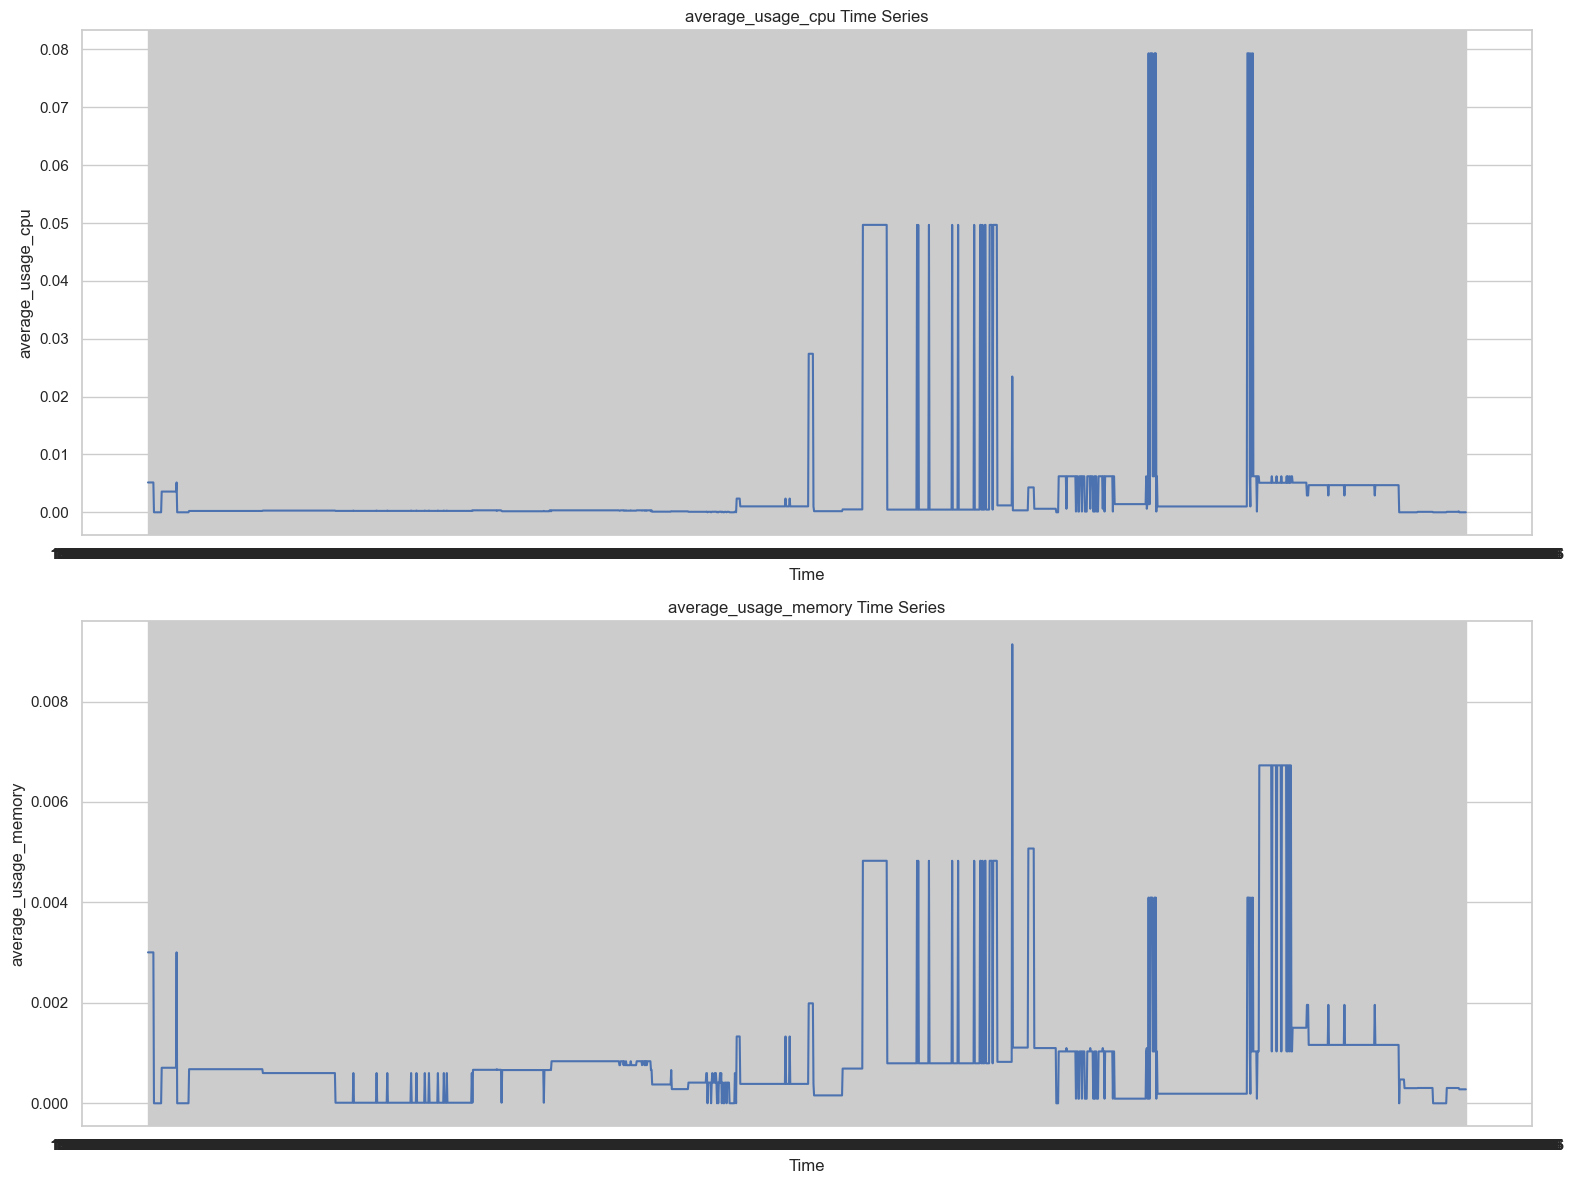

In [242]:
# 定义目标变量 (CPU和内存使用率)
target_vars = ['average_usage_cpu', 'average_usage_memory']

# 检查目标变量是否存在
target_vars = [var for var in target_vars if var in df.columns]

if target_vars:
    # 可视化目标变量分布
    fig, axes = plt.subplots(len(target_vars), 1, figsize=(12, 5*len(target_vars)))
    if len(target_vars) == 1:
        axes = [axes]
        
    for i, var in enumerate(target_vars):
        # 直方图
        sns.histplot(df[var], ax=axes[i], kde=True)
        axes[i].set_title(f'{var} Distribution')
        axes[i].set_xlabel(var)
    
    plt.tight_layout()
    plt.show()
    
    # 时间序列可视化
    if 'time_dt' in df.columns:
        fig, axes = plt.subplots(len(target_vars), 1, figsize=(16, 6*len(target_vars)))
        if len(target_vars) == 1:
            axes = [axes]
            
        for i, var in enumerate(target_vars):
            axes[i].plot(df['time_dt'], df[var])
            axes[i].set_title(f'{var} Time Series')
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel(var)
        
        plt.tight_layout()
        plt.show()
else:
    print("目标变量不存在于数据集中，请检查列名")

## 2. 特征工程

基于之前的模型结果和数据分析，我们将创建更多高级特征来提升模型性能。

### 2.1 时间特征创建

In [243]:
# 创建时间特征
def create_time_features(df, time_col='time_dt'):
    """从时间列创建丰富的时间特征"""
    print("\n创建时间特征...")
    
    # 确保列存在
    if time_col not in df.columns:
        print(f"列 {time_col} 不存在")
        return df
    
    # 复制数据框以避免修改原始数据
    df_new = df.copy()
    
    # 确保时间列是datetime类型
    df_new[time_col] = pd.to_datetime(df_new[time_col])
    print(f"转换 {time_col} 为datetime类型")
    
    # 从datetime创建特征
    df_new['hour_of_day'] = df_new[time_col].dt.hour
    df_new['day_of_week'] = df_new[time_col].dt.dayofweek
    df_new['day_of_month'] = df_new[time_col].dt.day
    df_new['month'] = df_new[time_col].dt.month
    
    # 创建周末指标 (0=工作日, 1=周末)
    df_new['is_weekend'] = df_new['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # 创建一天中的时段分类
    def get_day_part(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 22:
            return 'evening'
        else:
            return 'night'
    
    df_new['day_part'] = df_new['hour_of_day'].apply(get_day_part)
    
    # 对时段进行独热编码
    df_new = pd.get_dummies(df_new, columns=['day_part'], prefix='day_part')
    
    # 创建小时和日期的周期性特征（正弦和余弦变换）
    df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['day_sin'] = np.sin(2 * np.pi * df_new['day_of_week'] / 7)
    df_new['day_cos'] = np.cos(2 * np.pi * df_new['day_of_week'] / 7)
    
    return df_new

# 应用时间特征创建函数
if 'time_dt' in df.columns:
    df = create_time_features(df)
    print("已创建时间特征")
    
    # 显示新增的时间特征列
    time_feature_cols = ['hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos']
    time_feature_cols = [col for col in time_feature_cols if col in df.columns]
    
    if time_feature_cols:
        display(df[time_feature_cols].head())
else:
    print("无法创建时间特征，缺少time_dt列")


创建时间特征...
转换 time_dt 为datetime类型
已创建时间特征


,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos
0,10,6,1,0.5,-0.866025
1,10,6,1,0.5,-0.866025
2,10,6,1,0.5,-0.866025
3,10,6,1,0.5,-0.866025
4,10,6,1,0.5,-0.866025


### 2.2 滑动窗口特征（滞后特征）

In [244]:
# 创建滞后特征（基于排序后的时间序列）
def create_lag_features(df, target_cols, lag_periods=[1, 3, 6, 12, 24], sort_col='time_dt'):
    """为目标列创建滞后特征"""
    # 确保数据按时间排序
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # 为每个目标列和每个滞后周期创建特征
    for target in target_cols:
        for lag in lag_periods:
            # 创建滞后特征
            df_sorted[f'{target}_lag_{lag}'] = df_sorted[target].shift(lag)
    
    return df_sorted

# 创建滚动窗口统计特征
def create_rolling_features(df, target_cols, windows=[3, 6, 12, 24], sort_col='time_dt'):
    """为目标列创建滚动窗口统计特征"""
    # 确保数据按时间排序
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # 为每个目标列和每个窗口创建特征
    for target in target_cols:
        for window in windows:
            # 创建滚动平均值
            df_sorted[f'{target}_rolling_mean_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).mean()
            # 创建滚动标准差
            df_sorted[f'{target}_rolling_std_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).std()
            # 创建滚动最小值和最大值
            df_sorted[f'{target}_rolling_min_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).min()
            df_sorted[f'{target}_rolling_max_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).max()
    
    return df_sorted

# 应用滞后和滚动窗口特征创建
if 'time_dt' in df.columns and target_vars:
    # 创建滞后特征
    df = create_lag_features(df, target_vars)
    print("已创建滞后特征")
    
    # 创建滚动窗口特征
    df = create_rolling_features(df, target_vars)
    print("已创建滚动窗口特征")
    
    # 显示新增特征的前几行
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col][:5]
    if lag_cols:
        display(df[lag_cols].head(10))
else:
    print("无法创建时间序列特征，缺少必要的列")

已创建滞后特征
已创建滚动窗口特征


,average_usage_cpu_lag_1,average_usage_cpu_lag_3,average_usage_cpu_lag_6,average_usage_cpu_lag_12,average_usage_cpu_lag_24
0,NaN,NaN,NaN,NaN,NaN
1,0.005157,NaN,NaN,NaN,NaN
2,0.005157,NaN,NaN,NaN,NaN
3,0.005157,0.005157,NaN,NaN,NaN
4,0.005157,0.005157,NaN,NaN,NaN
5,0.005157,0.005157,NaN,NaN,NaN
6,0.005157,0.005157,0.005157,NaN,NaN
7,0.005157,0.005157,0.005157,NaN,NaN
8,0.005157,0.005157,0.005157,NaN,NaN
9,0.005157,0.005157,0.005157,NaN,NaN


### 2.3 资源使用率特征

In [245]:
# 创建资源使用率特征
def create_utilization_features(df):
    """创建资源使用率特征"""
    df_new = df.copy()
    
    # 检查必要的列是否存在
    if 'resource_request_cpu' in df.columns and 'average_usage_cpu' in df.columns:
        # CPU使用率 = 实际使用 / 请求资源
        df_new['cpu_utilization_ratio'] = df_new['average_usage_cpu'] / df_new['resource_request_cpu']
        # 处理无穷值
        df_new['cpu_utilization_ratio'] = df_new['cpu_utilization_ratio'].replace([np.inf, -np.inf], np.nan)
        # 上限为1（100%利用率）
        df_new['cpu_utilization_ratio'] = df_new['cpu_utilization_ratio'].clip(upper=1.0)
    
    if 'resource_request_memory' in df.columns and 'average_usage_memory' in df.columns:
        # 内存使用率 = 实际使用 / 请求资源
        df_new['memory_utilization_ratio'] = df_new['average_usage_memory'] / df_new['resource_request_memory']
        # 处理无穷值
        df_new['memory_utilization_ratio'] = df_new['memory_utilization_ratio'].replace([np.inf, -np.inf], np.nan)
        # 上限为1（100%利用率）
        df_new['memory_utilization_ratio'] = df_new['memory_utilization_ratio'].clip(upper=1.0)
    
    # 资源效率比率（如果CPU和内存指标都存在）
    if 'cpu_utilization_ratio' in df_new.columns and 'memory_utilization_ratio' in df_new.columns:
        # 资源平衡指标（接近1表示CPU和内存使用平衡）
        df_new['resource_balance_ratio'] = df_new['cpu_utilization_ratio'] / df_new['memory_utilization_ratio']
        # 处理无穷值
        df_new['resource_balance_ratio'] = df_new['resource_balance_ratio'].replace([np.inf, -np.inf], np.nan)
    
    return df_new

# 应用资源使用率特征创建
df = create_utilization_features(df)
print("已创建资源使用率特征")

# 显示新增特征
utilization_cols = ['cpu_utilization_ratio', 'memory_utilization_ratio', 'resource_balance_ratio']
utilization_cols = [col for col in utilization_cols if col in df.columns]
if utilization_cols:
    display(df[utilization_cols].head())

已创建资源使用率特征


,cpu_utilization_ratio,memory_utilization_ratio,resource_balance_ratio
0,0.732394,0.494354,1.481519
1,0.732394,0.494354,1.481519
2,0.732394,0.494354,1.481519
3,0.732394,0.494354,1.481519
4,0.732394,0.385896,1.897905


In [246]:
df

,user,time_dt,collection_id,collection_name,collection_logical_name,start_time_dt,end_time_dt,cpu_usage_distribution,tail_cpu_usage_distribution,priority,instance_index,event,failed,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour,hour_of_day,day_of_week,day_of_month,month,is_weekend,day_part_afternoon,day_part_evening,day_part_morning,day_part_night,hour_sin,hour_cos,day_sin,day_cos,average_usage_cpu_lag_1,average_usage_cpu_lag_3,average_usage_cpu_lag_6,average_usage_cpu_lag_12,average_usage_cpu_lag_24,average_usage_memory_lag_1,average_usage_memory_lag_3,average_usage_memory_lag_6,average_usage_memory_lag_12,average_usage_memory_lag_24,average_usage_cpu_rolling_mean_3,average_usage_cpu_rolling_std_3,average_usage_cpu_rolling_min_3,average_usage_cpu_rolling_max_3,average_usage_cpu_rolling_mean_6,average_usage_cpu_rolling_std_6,average_usage_cpu_rolling_min_6,average_usage_cpu_rolling_max_6,average_usage_cpu_rolling_mean_12,average_usage_cpu_rolling_std_12,average_usage_cpu_rolling_min_12,average_usage_cpu_rolling_max_12,average_usage_cpu_rolling_mean_24,average_usage_cpu_rolling_std_24,average_usage_cpu_rolling_min_24,average_usage_cpu_rolling_max_24,average_usage_memory_rolling_mean_3,average_usage_memory_rolling_std_3,average_usage_memory_rolling_min_3,average_usage_memory_rolling_max_3,average_usage_memory_rolling_mean_6,average_usage_memory_rolling_std_6,average_usage_memory_rolling_min_6,average_usage_memory_rolling_max_6,average_usage_memory_rolling_mean_12,average_usage_memory_rolling_std_12,average_usage_memory_rolling_min_12,average_usage_memory_rolling_max_12,average_usage_memory_rolling_mean_24,average_usage_memory_rolling_std_24,average_usage_memory_rolling_min_24,average_usage_memory_rolling_max_24,cpu_utilization_ratio,memory_utilization_ratio,resource_balance_ratio
0,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:38:32.222809,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,42,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.003090,1970-01-04 10:00:00,10,6,4,1,1,False,False,True,False,0.500000,-0.866025,-0.781831,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005157,NaN,0.005157,0.005157,0.005157,NaN,0.005157,0.005157,0.005157,NaN,0.005157,0.005157,0.005157,NaN,0.005157,0.005157,0.003006,NaN,0.003006,0.003006,0.003006,NaN,0.003006,0.003006,0.003006,NaN,0.003006,0.003006,0.003006,NaN,0.003006,0.003006,0.732394,0.494354,1.481519
1,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:38:32.892376,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,39,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.003090,1970-01-04 10:00:00,10,6,4,1,1,False,False,True,False,0.500000,-0.866025,-0.781831,0.623490,0.005157,NaN,NaN,NaN,NaN,0.003006,NaN,NaN,NaN,NaN,0.005157,0.0,0.005157,0.005157,0.005157,0.0,0.005157,0.005157,0.005157,0.000000,0.005157,0.005157,0.005157,0.000000,0.005157,0.005157,0.003006,0.0,0.003006,0.003006,0.003006,0.0,0.003006,0.003006,0.003006,0.000000,0.003006,0.003006,0.003006,0.000000,0.003006,0.003006,0.732394,0.494354,1.481519
2,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:39:00.576619,278969263399,Q+UsqiY4FMrvaXHc1TBfrAG5uDI0UsoO8HCOVqYC13s=,pGKT+Pe7CYfxdEOSllC0JrusGFHJBn/cmjQZdBU1Yvg=,1970-01-04 11:30:00,1970-01-04 11:35:00,[0.00306702 0.00402832 0.00437927 0.00469208 0...,[0.00636292 0.00640106 0.0064621 0.00654602 0...,103,18,SCHEDULE,0,0.007042,0.006081,0.005157,0.003006,0.021393,0.003090,1970-01-04 10:00:00,10,6,4,1,1,False,False,True,False,0.500000,-0.866025,-0.781831,0.623490,0.005157,

### 2.4 任务特性特征

In [247]:
## 处理任务特性特征
#task_features = ['priority', 'scheduling_class', 'collection_type', 'vertical_scaling', 'instance_index', 'failed']
#task_features = [col for col in task_features if col in df.columns]

#if task_features:
#    print(f"发现任务特性特征: {task_features}")
    
#    # 对分类特征进行独热编码
#    categorical_features = []
#    for col in task_features:
#        if df[col].dtype == 'object' or df[col].nunique() < 10:  # 分类特征判断条件
#            categorical_features.append(col)
    
#    if categorical_features:
#        print(f"将进行独热编码的分类特征: {categorical_features}")
#        df = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features)
        
#    # 显示处理后的前几行
#    new_cols = [col for col in df.columns if any(col.startswith(f"{feat}_") for feat in categorical_features)]
#    if new_cols:
#        display(df[new_cols[:5]].head())  # 只显示前5个新列
#else:
#    print("未找到任务特性特征")

### 2.5 内存和CPU效率指标

In [248]:
# 处理CPU和内存效率指标
efficiency_features = ['cycles_per_instruction', 'memory_accesses_per_instruction',
                       'assigned_memory', 'page_cache_memory']
efficiency_features = [col for col in efficiency_features if col in df.columns]

if efficiency_features:
    print(f"发现效率指标特征: {efficiency_features}")
    
    # 检查这些特征的缺失情况
    missing = df[efficiency_features].isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    for col, miss, pct in zip(efficiency_features, missing, missing_pct):
        print(f"{col}: {miss} 缺失值 ({pct:.2f}%)")
        
        # 如果缺失值不太多，使用中位数填充
        if pct < 50:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  - 使用中位数 {median_val:.6f} 填充缺失值")
            
    # 显示处理后的效率指标
    display(df[efficiency_features].describe())
    
    # 创建新的复合效率指标
    if 'cycles_per_instruction' in df.columns and 'memory_accesses_per_instruction' in df.columns:
        # 计算计算密集型指标 (高CPI, 低MAI意味着计算密集)
        df['compute_intensity'] = df['cycles_per_instruction'] / (df['memory_accesses_per_instruction'] + 0.001)
        print("已创建计算密集型指标")
        
    if 'assigned_memory' in df.columns and 'page_cache_memory' in df.columns:
        # 计算缓存使用比例
        df['cache_ratio'] = df['page_cache_memory'] / (df['assigned_memory'] + 0.0001)
        print("已创建缓存使用比例")
        
    # 显示新创建的指标
    new_metrics = ['compute_intensity', 'cache_ratio']
    new_metrics = [col for col in new_metrics if col in df.columns]
    if new_metrics:
        display(df[new_metrics].describe())
else:
    print("未找到效率指标特征")

未找到效率指标特征


## 3. 准备模型训练数据

In [249]:
def prepare_data_for_modeling(df, target_vars):
    """准备模型训练数据"""
    print("\n准备模型训练数据...")
    
    # 处理缺失值
    print("处理缺失值...")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                # 数值型列用中位数填充
                df[col] = df[col].fillna(df[col].median())
            else:
                # 非数值型列用众数填充
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # 删除无用列
    cols_to_drop = []
    
    # 删除高基数ID列
    id_cols = [col for col in df.columns if 'id' in col.lower() or 'name' in col.lower() or 'user' in col.lower()]
    cols_to_drop.extend(id_cols)
    
    # 删除原始时间戳列（保留转换后的dt列）
    timestamp_cols = [col for col in df.columns if ('time' in col.lower() and 'dt' not in col.lower())]
    cols_to_drop.extend(timestamp_cols)
    
    # 排除目标变量
    cols_to_drop = [col for col in cols_to_drop if col not in target_vars]
    
    # 删除全是NaN的列
    null_cols = df.columns[df.isnull().all()].tolist()
    cols_to_drop.extend(null_cols)
    
    # 删除列
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
    print(f"删除了 {len(cols_to_drop)} 列")
    
    # 将分类变量转换为数值
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        if col not in target_vars:  # 不转换目标变量
            # 对分类变量进行标签编码
            df[col] = pd.factorize(df[col])[0]
    
    print("数据准备完成")
    return df

df = prepare_data_for_modeling(df, target_vars)


准备模型训练数据...
处理缺失值...
删除了 4 列
数据准备完成


### 4. 构建模型

In [250]:
# 5. 可视化预测结果
xgb_model = None
scaler = None
def visualize_predictions_separate(y_true, predictions_dict, title_prefix="Prediction Comparison"):
    """Create a separate prediction vs true value comparison chart for each model"""

    # First, create an overview chart containing all models
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')

    for model_name, preds in predictions_dict.items():
        plt.plot(range(len(preds)), preds, '--', label=f'{model_name} Prediction')

    plt.title(f"{title_prefix} - Overview")
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"{title_prefix.replace(' ', '_')}_overview.png")
    plt.show()

    # Then, create a separate chart for each model
    for model_name, preds in predictions_dict.items():
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')
        plt.plot(range(len(preds)), preds, 'r--', label=f'{model_name} Prediction')

        plt.title(f"{title_prefix} - {model_name}")
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig(f"{title_prefix.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.show()

    print(f"Created {len(predictions_dict) + 1} prediction comparison charts")
# 4. 模型构建与评估
def evaluate_models(df, target_var, test_size=0.2, random_state=42):
    """Build and evaluate multiple prediction models"""
    print(f"\nEvaluating prediction models for {target_var}...")
    #global xgb_model, scaler

    # Prepare features and target
    y = df[target_var]
    X = df.drop(columns=[col for col in df.columns if col in [target_var] or col.startswith('time_')])

    print(f"Feature count: {X.shape[1]}")
    print(f"Sample count: {X.shape[0]}")

    # Create training and testing sets (time series split)
    # To ensure we don't use future data to predict the past, use the last test_size proportion of data as the test set
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Feature standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model result storage
    model_results = []

    # 1. XGBoost
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)
    xgb_model.fit(X_train_scaled, y_train)

    # Predict
    xgb_preds = xgb_model.predict(X_test_scaled)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
    mae = mean_absolute_error(y_test, xgb_preds)
    r2 = r2_score(y_test, xgb_preds)

    print(f"XGBoost - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    model_results.append({"model": "XGBoost", "rmse": rmse, "mae": mae, "r2": r2})

    # Summarize results
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values('rmse')

    print("\nModel performance summary:")
    print(results_df)

    # 可视化预测结果
    # 收集预测结果用于可视化
    predictions_dict = {}
    if 'xgb_preds' in locals():
        predictions_dict['XGBoost'] = xgb_preds

    visualize_predictions_separate(
        y_true=y_test,
        predictions_dict=predictions_dict,
        title_prefix=f"{target_var} Prediction Comparison"
    )

    # Return the best model and evaluation results
    return results_df


Evaluating prediction models for average_usage_cpu...
Feature count: 51
Sample count: 2215
Training set shape: (1772, 51), Test set shape: (443, 51)

Training XGBoost...
XGBoost - RMSE: 0.001621, MAE: 0.001069, R²: 0.968386

Model performance summary:
     model      rmse       mae        r2
0  XGBoost  0.001621  0.001069  0.968386


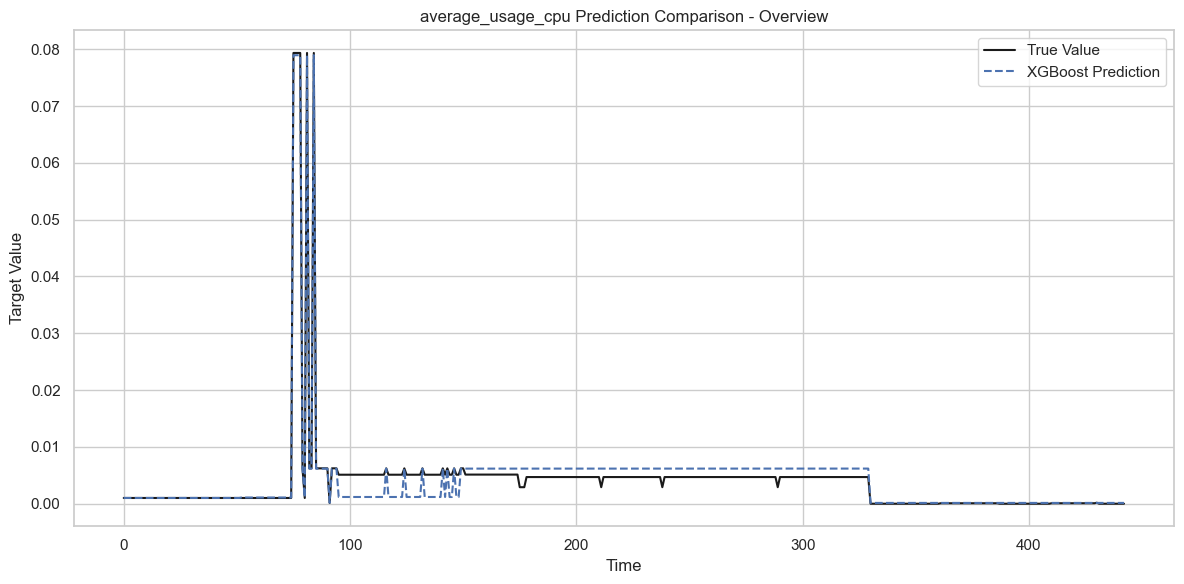

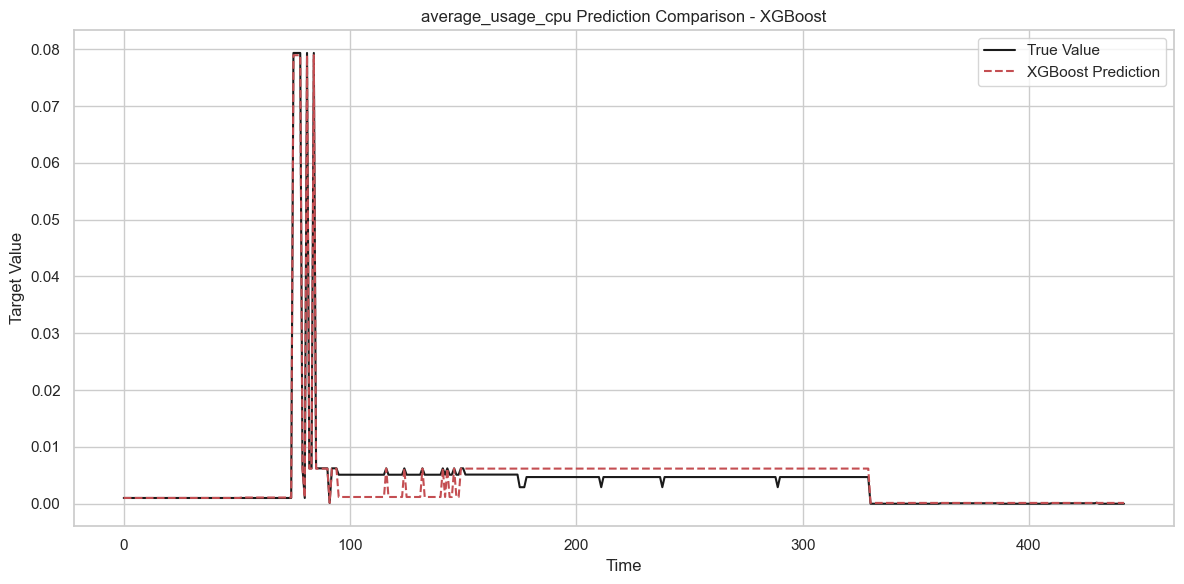

Created 2 prediction comparison charts

Evaluating prediction models for average_usage_memory...
Feature count: 51
Sample count: 2215
Training set shape: (1772, 51), Test set shape: (443, 51)

Training XGBoost...
XGBoost - RMSE: 0.000788, MAE: 0.000379, R²: 0.836590

Model performance summary:
     model      rmse       mae       r2
0  XGBoost  0.000788  0.000379  0.83659


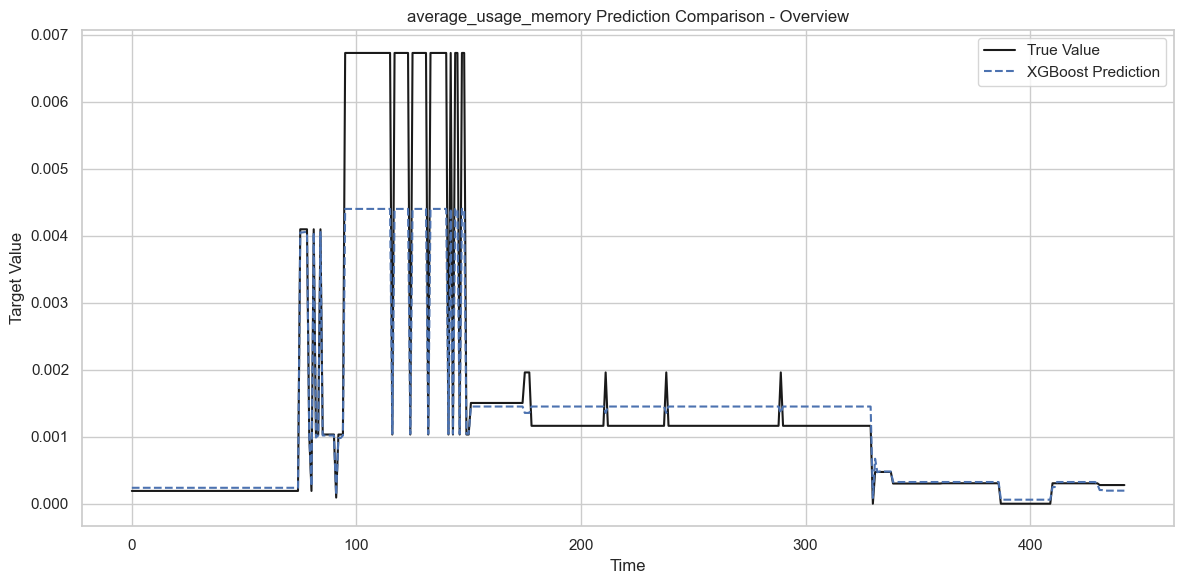

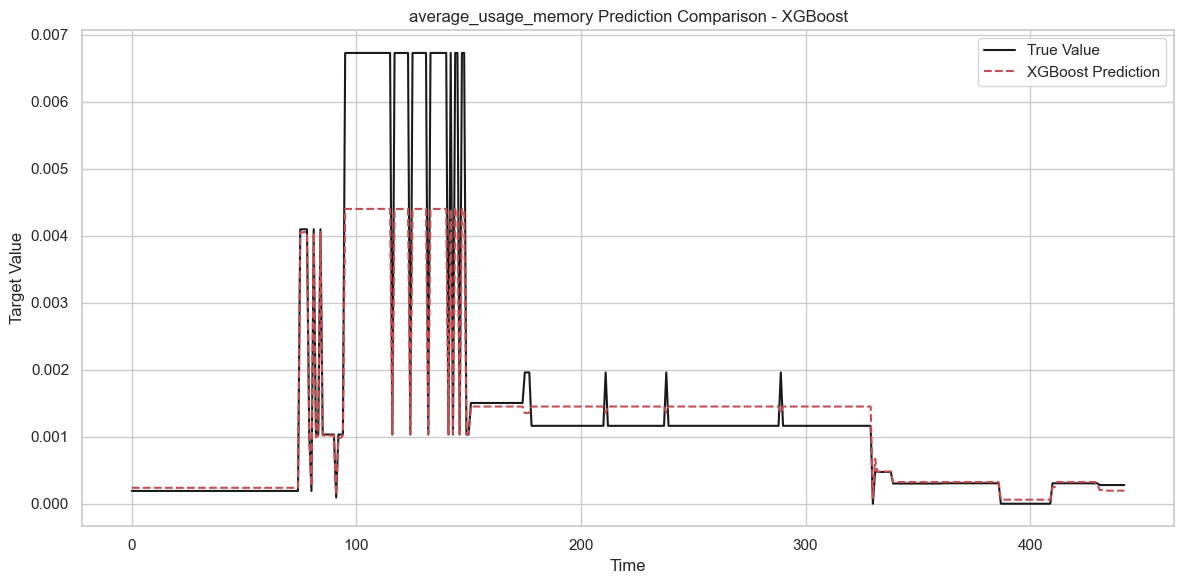

Created 2 prediction comparison charts
建模完成！


In [251]:
for target_var in target_vars:
    # 过滤掉含有NaN的行
    df_clean = df.dropna(subset=[target_var])

    # 过滤掉其他目标变量的滞后特征
    other_targets = [t for t in target_vars if t != target_var]
    cols_to_drop = []
    for other_target in other_targets:
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_lag_")])
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_rolling_")])

    df_model = df_clean.drop(columns=cols_to_drop, errors='ignore')
    # 构建和评估模型
    results_df = evaluate_models(df_model, target_var)
    #results_df.to_csv(f"model_results_{target_var}.csv", index=False)
print("建模完成！")

In [252]:
# 5. Save trained models and scalers
#def save_model(model, scaler, target_var, model_dir='../models'):
#    """Save models and scalers to a specified directory"""
#    # Ensure the directory exists
#    os.makedirs(model_dir, exist_ok=True)
    
#    # Save the model
#    model_path = os.path.join(model_dir, f'xgboost_{target_var}.pkl')
#    joblib.dump(model, model_path)
#    print(f"Model saved to: {model_path}")
    
#    # Save the scaler
#    scaler_path = os.path.join(model_dir, f'scaler_{target_var}.pkl')
#    joblib.dump(scaler, scaler_path)
#    print(f"Feature scaler saved to: {scaler_path}")
    
#    return model_path, scaler_path

In [253]:
# 保存模型（执行上面定义的训练循环后）
#if xgb_model is not None and scaler is not None:
    #print("hi")
#for target_var in target_vars:
#    save_model(xgb_model, scaler, target_var)

In [266]:
# 6. 加载保存的模型和缩放器
def load_model(target_var, model_dir='../models'):
    """从文件加载模型和缩放器"""
    if 'memory' in target_var.lower():
        model_path = os.path.join(model_dir, f'xgb_model_colab_memory.pkl')
        scaler_path = os.path.join(model_dir, f'scaler_colab_memory.pkl')
    elif 'cpu' in target_var.lower():
        model_path = os.path.join(model_dir, f'xgb_model_colab_cpu.pkl')
        scaler_path = os.path.join(model_dir, f'scaler_colab_cpu.pkl')
    
    try:
        model = joblib.load(model_path)
        print(f"已加载模型: {model_path}")
        
        scaler = joblib.load(scaler_path)
        print(f"已加载特征缩放器: {scaler_path}")
        
        return model, scaler
    except Exception as e:
        print(f"加载模型和缩放器时出错: {e}")
        return None, None

In [267]:
# 7. Make predictions using the loaded model
def make_predictions(model, scaler, df, target_var):
    """Make predictions on new data using the loaded model and scaler"""
    print(f"\nMaking predictions for {target_var} using the loaded model...")
    
    # Prepare features
    X = df.drop(columns=[col for col in df.columns if col in target_vars or col.startswith('time_')])
    
    # Apply scaler
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = model.predict(X_scaled)
    
    # Add prediction results to the dataframe
    df_with_preds = df.copy()
    df_with_preds[f'{target_var}_predicted'] = predictions
    
    print(f"Generated {len(predictions)} predictions")
    return df_with_preds, predictions

In [268]:
# 8. 将数据和预测结果可视化
def visualize_predictions(df, target_var, max_points=1000):
    """可视化目标变量的实际值和预测值"""
    prediction_col = f'{target_var}_predicted'
    
    if prediction_col not in df.columns:
        print(f"错误: 没有找到预测列 {prediction_col}")
        return
    
    # 如果数据点太多，进行采样
    if len(df) > max_points:
        df_sample = df.sample(max_points)
        print(f"数据点太多，随机采样 {max_points} 个点进行可视化")
    else:
        df_sample = df
    
    # 创建可视化
    plt.figure(figsize=(15, 6))
    
    # 如果有时间列，使用它作为x轴
    if 'time_dt' in df_sample.columns:
        plt.plot(df_sample['time_dt'], df_sample[target_var], 'b-', label='实际值')
        plt.plot(df_sample['time_dt'], df_sample[prediction_col], 'r--', label='预测值')
        plt.xlabel('时间')
    else:
        plt.plot(range(len(df_sample)), df_sample[target_var], 'b-', label='实际值')
        plt.plot(range(len(df_sample)), df_sample[prediction_col], 'r--', label='预测值')
        plt.xlabel('数据点')
    
    plt.ylabel(target_var)
    plt.title(f'{target_var} 预测与实际值对比')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # 保存图像
    #plt.savefig(f"{target_var}_predictions.png")
    plt.show()
    
    # 计算并显示指标
    rmse = np.sqrt(mean_squared_error(df_sample[target_var], df_sample[prediction_col]))
    mae = mean_absolute_error(df_sample[target_var], df_sample[prediction_col])
    r2 = r2_score(df_sample[target_var], df_sample[prediction_col])
    
    print(f"预测性能指标:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")

In [269]:
# 9. 执行端到端的预测和可视化流程
def predict_and_visualize(df, target_var, model_dir='../models'):
    """从加载模型到可视化预测结果的端到端流程"""
    # 加载模型和缩放器
    model, scaler = load_model(target_var, model_dir)
    
    if model is None or scaler is None:
        print("无法完成预测，模型或缩放器加载失败")
        print(f"模型类型: {type(model)}")
        print(f"缩放器类型: {type(scaler)}")
        return
    
    # 使用模型进行预测
    df_with_preds, _ = make_predictions(model, scaler, df, target_var)
    
    # 可视化预测结果
    visualize_predictions(df_with_preds, target_var)
    
    # 保存带预测值的数据
    output_dir = '../prediction_results'
    os.makedirs(output_dir, exist_ok=True)
    #df_with_preds.to_csv(os.path.join(output_dir, f'{target_var}_predictions.csv'), index=False)
    print(f"预测结果已保存至 {output_dir}/{target_var}_predictions.csv")
    
    return df_with_preds

In [270]:
# 10. 预测多个未来时间点（递归预测）
def predict_future(model, scaler, last_data, target_var, steps=24, feature_cols=None):
    """使用递归策略预测未来时间点"""
    print(f"\n预测 {target_var} 的未来 {steps} 个时间点...")
    
    # 复制最后的数据点作为起点
    future_data = last_data.copy()
    predictions = []
    
    # 获取正确的特征集
    if hasattr(scaler, 'feature_names_in_'):
        # scikit-learn 1.0+ 直接从scaler获取特征名
        feature_cols = scaler.feature_names_in_
    elif feature_cols is None:
        # 过滤掉其他目标变量的特征
        target_vars = ['average_usage_cpu', 'average_usage_memory']
        other_targets = [t for t in target_vars if t != target_var]
        
        # 从future_data中排除所有目标变量及其衍生特征
        excluded_patterns = []
        for other_target in other_targets:
            excluded_patterns.extend([f"{other_target}_lag_", f"{other_target}_rolling_"])
        
        feature_cols = [col for col in future_data.columns 
                      if col not in target_vars 
                      and not col.startswith('time_')
                      and not any(col.startswith(pattern) for pattern in excluded_patterns)]
    
    print(f"使用 {len(feature_cols)} 个特征进行预测")
    
    # 检查特征匹配
    missing_features = [col for col in feature_cols if col not in future_data.columns]
    if missing_features:
        raise ValueError(f"数据中缺少以下特征: {missing_features}")
    
    # 递归预测
    for step in range(steps):
        # 准备特征
        X = future_data[feature_cols].values.reshape(1, -1)
        
        # 应用缩放器
        X_scaled = scaler.transform(X)
        
        # 预测下一个点
        pred = model.predict(X_scaled)[0]
        predictions.append(pred)
        
        # 更新数据用于下一次预测
        # 更新目标变量
        future_data[target_var] = pred
        
        # 更新滞后特征（如果存在）
        for lag in range(1, 25):  # 假设最大滞后为24
            lag_col = f'{target_var}_lag_{lag}'
            if lag_col in feature_cols and lag_col in future_data.columns:
                # 滞后1是当前值，滞后2变成滞后1，以此类推
                if lag == 1:
                  future_data[lag_col] = pred
                elif f'{target_var}_lag_{lag-1}' in future_data.columns:
                    future_data[lag_col] = future_data[f'{target_var}_lag_{lag-1}']
        
        # 更新滚动特征（如果存在）
        for window in [3, 6, 12, 24]:  # 常见窗口大小
            mean_col = f'{target_var}_rolling_mean_{window}'
            if mean_col in feature_cols and mean_col in future_data.columns:
                # 简化：用当前预测值更新
                future_data[mean_col] = pred
    
    return predictions

In [275]:
# 11. 可视化未来预测
def visualize_future_predictions(historical_data, future_predictions, target_var, 
                                prediction_start_idx, interval=1):
    """可视化历史数据和未来预测"""
    plt.figure(figsize=(15, 6))
    
    # 历史数据的时间范围
    historical_times = range(len(historical_data))
    plt.plot(historical_times, historical_data[target_var], 'b-', label='Historical Data')
    
    # Time range for future predictions
    future_times = range(prediction_start_idx, prediction_start_idx + len(future_predictions) * interval, interval)
    plt.plot(future_times, future_predictions, 'r--', label='Future Predictions')
    
    # Adding a separation line to indicate the start of predictions
    plt.axvline(x=prediction_start_idx, color='green', linestyle='--', label='Prediction Start')
    
    plt.xlabel('Time Points')
    plt.ylabel(target_var)
    plt.title(f'{target_var} Historical Data and Future Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # 保存图像
    #plt.savefig(f"{target_var}_future_predictions.png")
    plt.show()

已加载模型: ../models/xgb_model_colab_cpu.pkl
已加载特征缩放器: ../models/scaler_colab_cpu.pkl

预测 average_usage_cpu 的未来 100 个时间点...
使用 51 个特征进行预测


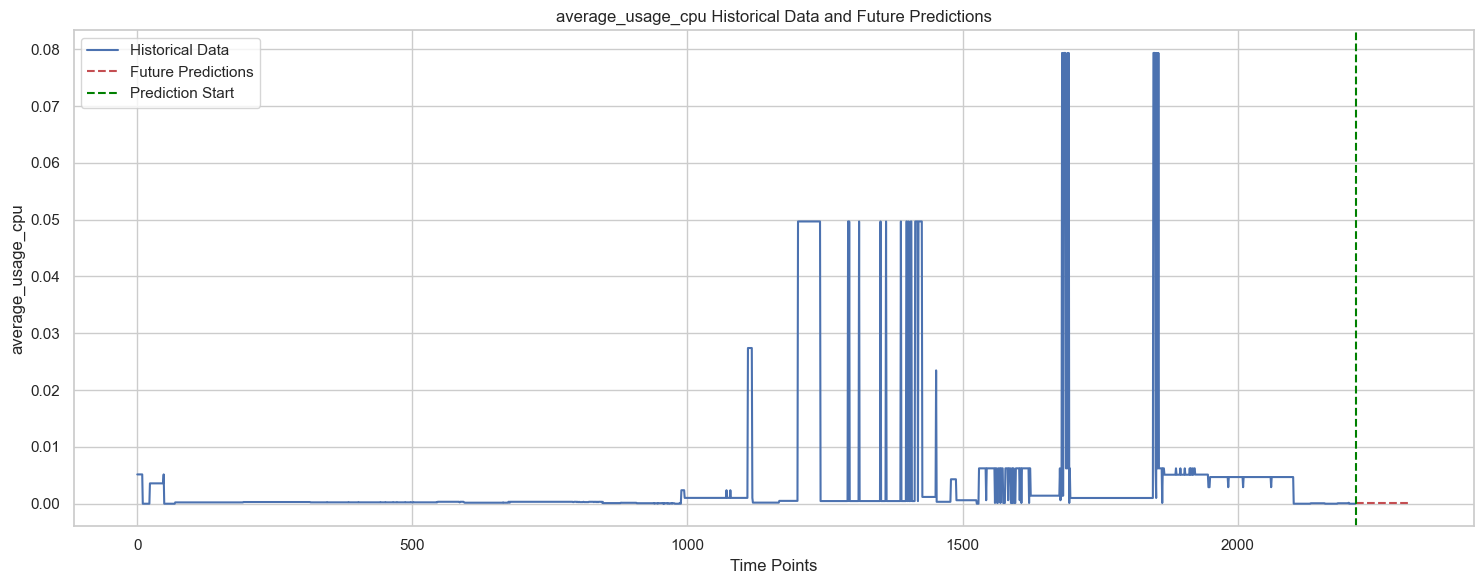

In [277]:
# 12. 示例：如何使用这些函数
#print("\n演示如何使用预测功能:")
#print("1. 对现有数据进行预测")
#print("   predict_and_visualize(df, 'average_usage_cpu')")
#print("\n2. 预测未来时间点")
#print("   model, scaler = load_model('average_usage_cpu')")
#print("   last_data = df.iloc[-1:]  # 使用最后一个时间点的数据")
#print("   future_preds = predict_future(model, scaler, last_data, 'average_usage_cpu', steps=24)")
#print("   visualize_future_predictions(df, future_preds, 'average_usage_cpu', len(df))")

# 可以取消下面的注释来实际运行预测示例
predict_feature = 'average_usage_cpu'
#predict_and_visualize(df, 'average_usage_cpu')
model, scaler = load_model(predict_feature)
last_data = df.iloc[-1:]
future_preds = predict_future(model, scaler, last_data, predict_feature, steps=100)
visualize_future_predictions(df, future_preds, predict_feature, len(df))

已加载模型: ../models/xgb_model_colab_memory.pkl
已加载特征缩放器: ../models/scaler_colab_memory.pkl

预测 average_usage_memory 的未来 1000 个时间点...
使用 51 个特征进行预测


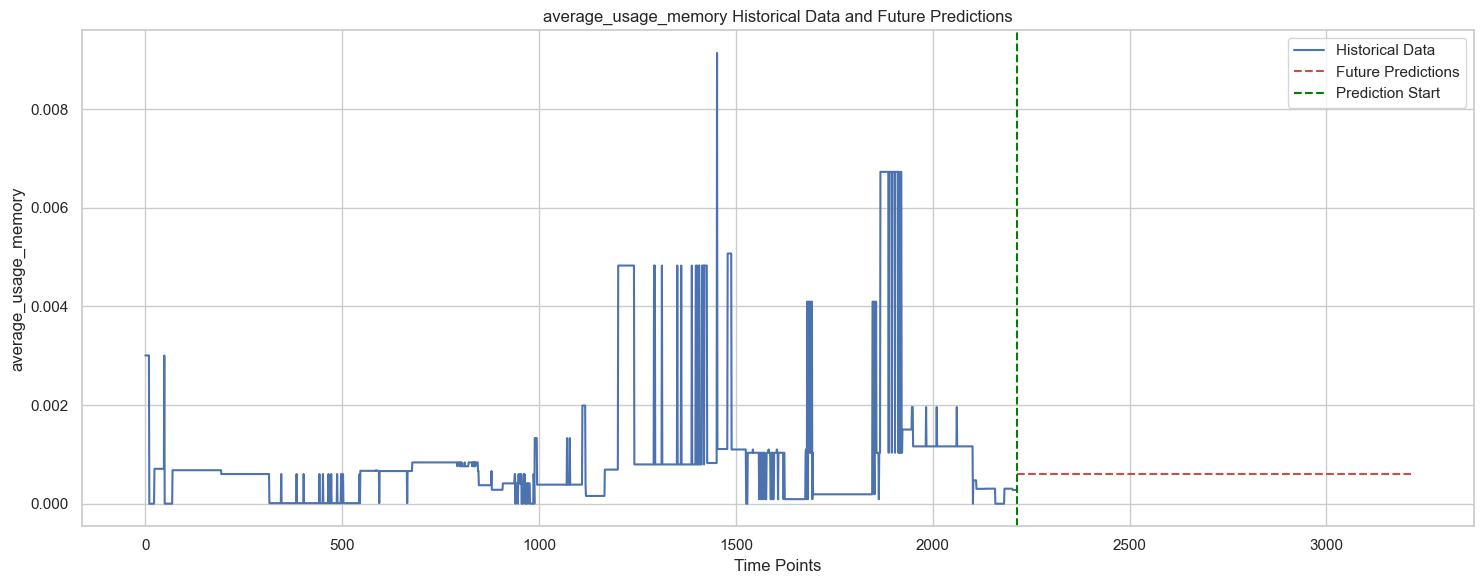

In [ ]:
predict_feature = 'average_usage_memory'
model, scaler = load_model(predict_feature)
last_data = df.iloc[-1:]
future_preds = predict_future(model, scaler, last_data, predict_feature, steps=100)
visualize_future_predictions(df, future_preds, predict_feature, len(df))